# **Notebook Setup**

Here we set up the import statements and load the data into dataframes.

In [1]:
# Import statements

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from pandas import DataFrame

In [2]:
# import data into dfs
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

# **Investigating the data**

Here we look at the data in the most basic terms to get a better sense for missing values, types of data, and potential features we could use. 

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Initial Impressisons**

1. String objects including ['Gender', 'Name', 'Ticket', 'Cabin', 'Embarked'] will need to be encoded to numerical values.
2. Names look to be unique and may be a useful feature if I can pull out titles from the strings. 
3. Fare will might be a useful feature if I can correlate it to survival rate. 
4. Cabin looks to have a lot of missing values and will be a hard feature to use. 
5. Age, Gender, and # of family members might offer promise as features. 
6. Data will have to be normalized to accound for the wide range of values between features. 

# **Investigation of Potential Features**

Here I will investigate what features will be useful by visualizing the graphically.

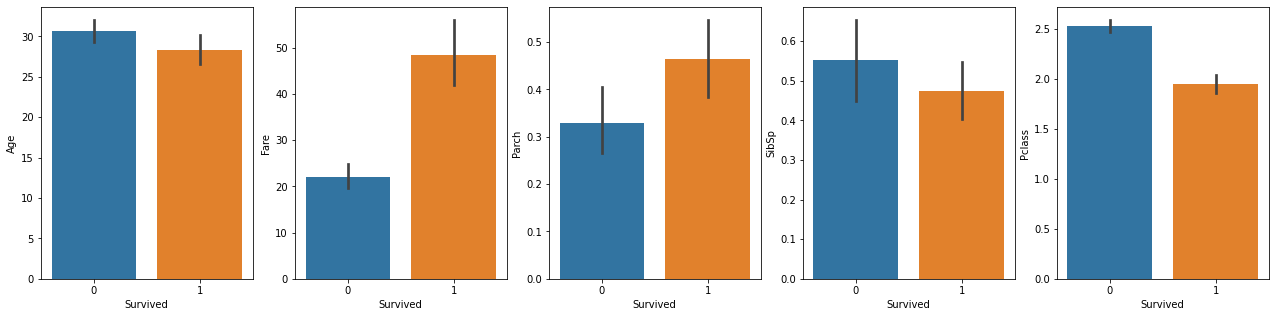

In [6]:
fig, axes = plt.subplots(1, 5, figsize = (22, 5))
columns = ['Age', 'Fare', 'Parch', 'SibSp', 'Pclass']

for col in columns: 
    sns.barplot(ax=axes[columns.index(col)], data = train, x = 'Survived', y = col)

**Conclusion**
1. I will need to bin ages to see if there is an unequal distibution of survived. 
2. Fare seems to be a good predictor of survival and I will include it as a feature in my model. 
3. I will need to break down Pclass into categories

<AxesSubplot:xlabel='Embarked', ylabel='count'>

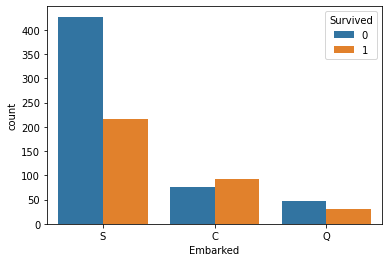

In [7]:
sns.countplot(data = train, x = 'Embarked', hue = 'Survived')

Those that embarked on C were more likley to survive, therefore Embarked will be used as a feature. 

<AxesSubplot:xlabel='Sex', ylabel='count'>

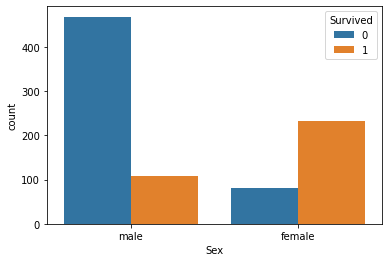

In [8]:
sns.countplot(data = train, x = 'Sex', hue = 'Survived')

Males were less likely to survive that females and therefore sex should be included as a feature.

In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [10]:
X = train.drop(columns=['Name', 'Cabin', 'Ticket', 'Survived', 'PassengerId'])
y = train['Survived']

In [11]:
X_test = test.drop(columns=['Name', 'Cabin', 'Ticket', 'PassengerId'])
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Fill in missing values with mean value or most common value

In [12]:
X['Age'].fillna(X['Age'].mean(), inplace = True)
X['Embarked'].fillna('S', inplace = True)

In [13]:
X_test['Age'].fillna(X_test['Age'].mean(), inplace = True)
X_test['Embarked'].fillna('S', inplace = True)
X_test['Fare'].fillna(X_test['Fare'].mean(), inplace = True)

In [14]:
# check to make sure all NA have been handled
X.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

In [15]:
X_test.isna().sum()

Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64

Encode values for Sex and Embarked

In [16]:
le = preprocessing.LabelEncoder()

X['Sex'] = le.fit_transform(X['Sex'])
X['Embarked'] = le.fit_transform(X['Embarked'])
X.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,2
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,2
3,1,0,35.0,1,0,53.1000,2
4,3,1,35.0,0,0,8.0500,2


In [17]:
X_test['Sex'] = le.fit_transform(X_test['Sex'])
X_test['Embarked'] = le.fit_transform(X_test['Embarked'])
X_test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2
2,2,1,62.0,0,0,9.6875,1
3,3,1,27.0,0,0,8.6625,2
4,3,0,22.0,1,1,12.2875,2


In [18]:
scaler = MinMaxScaler(feature_range = (0,1))
X_2 = scaler.fit_transform(X)
X_test_scaled = scaler.fit_transform(X_test)


In [19]:
X_test_final = DataFrame(X_test_scaled)
X_final = DataFrame(X_2)
X_final.head()

,0,1,2,3,4,5,6
0,1.0,1.0,0.271174,0.125,0.0,0.014151,1.0
1,0.0,0.0,0.472229,0.125,0.0,0.139136,0.0
2,1.0,0.0,0.321438,0.000,0.0,0.015469,1.0
3,0.0,0.0,0.434531,0.125,0.0,0.103644,1.0
4,1.0,1.0,0.434531,0.000,0.0,0.015713,1.0


In [20]:
X_train, X_valid, y_train, y_valid = train_test_split(X_final, y, test_size=0.33, random_state=1)

In [21]:
print(X_train.shape)

(596, 7)


To-do:
1. Make model
2. Fit model
3. Preprocess test data
4. Optimize data

In [22]:
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=10, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [23]:
model = keras.Sequential([
    layers.Dense(500, activation ='relu', input_shape=[7]),
    layers.Dropout(0.3),
    layers.Dense(500, activation ='relu'),
    layers.Dropout(0.3),
    layers.Dense(500, activation ='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation ='sigmoid'),
])

2022-07-07 14:34:30.488019: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [24]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [25]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=256,
    epochs=500,
    callbacks=[early_stopping],
    verbose=0,
)

2022-07-07 14:34:30.811108: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Best Validation Loss: 0.4896
Best Validation Accuracy: 0.7864


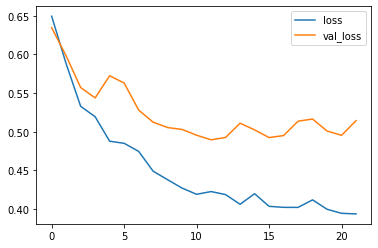

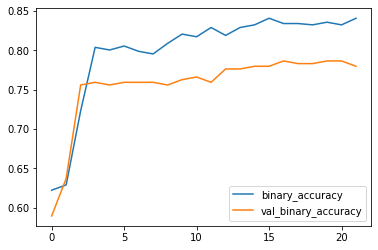

In [26]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot()

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))


In [27]:
result = model.predict(X_test_final)
# output = pd.DataFrame({'PassengerId': test.PassengerId})
# output['Survived'] = result.tolist()
# output.head()

In [28]:
result=np.transpose(result)[0]
result = list(map(lambda x: 0 if x<0.5 else 1, result))
print(result)

[0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 

In [29]:
output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': result})
output.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [30]:
output.to_csv('submission.csv', index=False)